In [1]:
# Import libraries, packages, modules, functions, etc...
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import skimage
from skimage.restoration import denoise_nl_means, estimate_sigma, denoise_tv_chambolle, denoise_bilateral,denoise_wavelet, unsupervised_wiener
from scipy.signal import convolve2d as conv2
from skimage.filters import median
import copy
from tqdm import tqdm
from scipy import ndimage as nd
import multiprocessing
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
from itertools import repeat
import zipfile
import os
from IPython.display import FileLink
from sklearn.svm import SVC
from keras.callbacks import EarlyStopping
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing import image
from skimage.morphology import disk
from tensorflow.keras.optimizers import SGD
warnings.simplefilter(action='ignore', category=FutureWarning)
!pip install natsort
!pip install MedPy
import natsort
from medpy.filter.smoothing import anisotropic_diffusion
%matplotlib inline

In [2]:
#pip install opencv-python

In [3]:
#pip install tensorflow

## Data Accumulation

In [4]:
# Get the complete data of kidney stone images
import os
def Get_data(dir, catagories, data):
    for category in catagories:
        path = os.path.join(dir, category)
        class_number = catagories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path , img))
                new_image = cv2.resize(img_array,(128,128))
                data.append([new_image , class_number])
            except Exception as e:
                pass

data = []
# Augmented Dataset
# Get_data("/kaggle/input/combined-aug-ks/KS_Detection", ["Combined_N", "Combined_KS"], data)

# Original Dataset
Get_data("C:/Users/prajwal mr/Downloads/archive/CT_SCAN", ["Kidney_stone", "Normal"], data)

In [5]:
catagories = ["Kidney_stone", "Normal"]
print(catagories.index("Kidney_stone"))
print(catagories.index("Normal"))

0
1


In [6]:
print('Number of kidney stone images',len(os.listdir('C:/Users/prajwal mr/Downloads/archive/CT_SCAN/Kidney_stone')))
print('Number of Normal kidney images',len(os.listdir('C:/Users/prajwal mr/Downloads/archive/CT_SCAN/Normal')))

Number of kidney stone images 781
Number of Normal kidney images 828


(128, 128, 3)


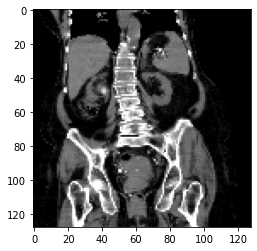

In [7]:
print(data[143][0].shape)
plt.imshow(data[143][0])
plt.show()

In [8]:
# Extract Features and Labels from the data
Features = []
Labels = []
for features , labels in data:
    Features.append(features)
    Labels.append(labels)
Features = np.array(Features)
Labels = np.array(Labels)

In [9]:
Features[5][1]

array([[  0,   0,   0],
       [ 88,  88,  88],
       [  0,   0,   0],
       [  0,   0,   0],
       [  2,   2,   2],
       [  6,   6,   6],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  1,   1,   1],
       [  4,   4,   4],
       [ 15,  15,  15],
       [ 90,  90,  90],
       [  1,   1,   1],
       [  0,   0,   0],
       [  4,   4,   4],
       [ 37,  37,  37],
       [ 75,  75,  75],
       [113, 113, 113],
       [118, 118, 118],
       [121, 121, 121],
       [106, 106, 106],
       [135, 135, 135],
       [ 33,  33,  33],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0

In [10]:
# Shape of Features and Labels
print(Features.shape)
print(Labels.shape)

(1609, 128, 128, 3)
(1609,)


# PREPROCESSING

In [11]:
def Processed(Processed_images):
    img_per_row = 4
    fig, ax = plt.subplots(nrows = 2, ncols = img_per_row, figsize=(10,10), subplot_kw = dict(xticks = [], yticks = []))
    for row in [0, 1]:
        for col in range(img_per_row):
            if(row * img_per_row + col == 7):
                break
            if(Processed_images[row * img_per_row + col][1] == "Bilateral_Denoised" or Processed_images[row * img_per_row + col][1] == "Wavelet_Denoised" or Processed_images[row * img_per_row + col][1] == "Non_Local_Means"):
                ax[row, col].imshow(Processed_images[row * img_per_row + col][0].astype('float64'), cmap = "gray")
            else:
                ax[row, col].imshow(Processed_images[row * img_per_row + col][0].astype('uint8'), cmap = "gray")
            ax[row, col].set_title(Processed_images[row * img_per_row + col][1])
            plt.axis('off')
    plt.show()

In [12]:
# Filters


# Efficient in reducing gaussian image
# Lowers the image resolution
def AnisotropicFilter_wholedataset(noised_dataset, niter, kappa, gamma, option, size):
    anisotropic_dataset = copy.deepcopy(noised_dataset)
    for i in tqdm(range(anisotropic_dataset.shape[0])):
        anisotropic_dataset[i] = anisotropic_diffusion(noised_dataset[i, :, :, :], niter=niter, kappa=kappa, gamma=gamma, option=option).reshape(size, size, 1)
    return anisotropic_dataset


# Reduce spiky noise
# Non linear filter
# Smoothens the image
# Prevent blur and preserve sharp edges 
# Only better for removing salt and pepper noise
def median_wholedataset(noised_dataset, filtersize, size):
    median_wholedata = copy.deepcopy(noised_dataset)
    for i in tqdm(range(noised_dataset.shape[0])):
        median_wholedata[i] = median(noised_dataset[i,:,:,:][:,:,0], np.ones((filtersize, filtersize))).reshape(size, size, 1)
    return median_wholedata


# Regardless of the frequency composition of the signal, eliminate noise while keeping its properties 
# Unable to preserve fine details in case of high noise data.
# There's a chance the wavelet coefficients are biased
def wavelet_wholedataset(noised_dataset, sigma, wavelet_levels, size):
    wavelet_wholedata = copy.deepcopy(noised_dataset)
    for i in tqdm(range(noised_dataset.shape[0])):
        wavelet_wholedata[i] = denoise_wavelet(noised_dataset[i,:,:,:], sigma=sigma, channel_axis=-1, wavelet_levels=wavelet_levels, rescale_sigma=True).reshape(size, size, 1)
    return wavelet_wholedata


# Better in preserving edges
# Effectively remove gaussian noise
# Not the best fit for salt and pepper noise
def BilateralFilter_wholedataset(noised_dataset, sigma_color, sigma_spatial, channel_axis, size):
    bilateral_dataset = copy.deepcopy(noised_dataset)
    for i in tqdm(range(bilateral_dataset.shape[0])):
        bilateral_dataset[i] = denoise_bilateral(noised_dataset[i, :, :, :], sigma_color = sigma_color, sigma_spatial=sigma_spatial, channel_axis=channel_axis).reshape(size, size, 1)
    return bilateral_dataset


# Effect for gaussian noise
# Simplicity of algorithm is one of the pros
# Reduce the image details
# Unable to preserve edges
# Denoised images would be blurry.
def GaussianFilter_wholedataset(noised_dataset, sigma):
    gaussian_dataset = copy.deepcopy(noised_dataset)
    for i in tqdm(range(gaussian_dataset.shape[0])):
        gaussian_dataset[i] = nd.gaussian_filter(tuple(noised_dataset[i, :, :, :]), sigma=sigma)
    return gaussian_dataset


# Preserve edges
# Better performance with redundant images
# Expensive, so non-suggestable for larger noise
def non_local_mean(image):
    sigma_est = np.mean(estimate_sigma(image, channel_axis=-1))
    patch_kw = dict(patch_size = 5,      # 5x5 patches
                patch_distance = 6,  # 13x13 search area
                channel_axis = -1)
    denoise_fast = denoise_nl_means(image, h = 0.6 * sigma_est, sigma=sigma_est, fast_mode=True, **patch_kw)
    return denoise_fast


# Apply bilateral filter with d = 15
# sigmaColor = sigmaSpace = 75
# d: Diameter of each pixel neighborhood.
# sigmaColor: Value of sigma  in the color space. The greater the value, the colors farther to each other will start to get mixed.
# sigmaSpace: Value of sigma  in the coordinate space. The greater its value, the more further pixels will mix together, given that their colors lie within the sigmaColor range.
def cv2bilateralFilter(image, d, sigmaColor, sigmaSpace):
    bilateral = cv2.bilateralFilter(image, d, sigmaColor, sigmaSpace)
    bilateral = bilateral.astype('uint8')
    return bilateral




# Execution
# ani = AnisotropicFilter_wholedataset(noised_dataset, 50, 20, 0.2, 1)
# bi = BilateralFilter_wholedataset(noised_dataset, 15, -1)
# gauss = GaussianFilter_wholedataset(noised_dataset, 2)

# median_img = median(Features[0, :, :, :][:,:,0], disk(3), mode = 'constant', cval = 0.0).reshape(128, 128, 1)
# wavelet_img = denoise_wavelet(Features[0, :, :, :], sigma = 0.12, channel_axis = -1,convert2ycbcr=True, method='BayesShrink', mode='soft', rescale_sigma=True).reshape(128, 128, 3)
# bilateral_image = denoise_bilateral(Features[0], sigma_spatial = 10, channel_axis = -1)
# anisotropic_image = anisotropic_diffusion(Features[700,:,:,:][:,:,0], niter = 100, kappa = 10, gamma = 0.02, option=1)
# anisotropic_image = anisotropic_diffusion(Features[700,:,:,:][:,:,0], niter = 50, kappa = 10, gamma = 0.02, option=1)
# anisotropic_image = anisotropic_diffusion(Features[60,:,:,:][:,:,0], niter = 50, kappa = 5, gamma = 0.005, option=1)
# anisotropic_image = anisotropic_diffusion(Features[600,:,:,:][:,:,0], niter = 50, kappa = 5, gamma = 0.000001, option=1)
# anisotropic_image = anisotropic_image.astype('uint8')


# Metrics
def psnr_wholedataset(dataset_original, dataset_denoised):

    sumpsnr = 0
    avgpsnr = 0
    for i in tqdm(range(dataset_original.shape[0])):
        true_min, true_max = np.min(dataset_original[i, :, :, :]), np.max(dataset_original[i, :, :, :])
        dataRange = abs(true_min)+abs(true_max)
        psnr = peak_signal_noise_ratio(dataset_original[i], dataset_denoised[i], data_range=dataRange)
        sumpsnr += psnr
    avgpsnr = sumpsnr/dataset_original.shape[0]     

    return avgpsnr

# psnr_wholedataset(data, noised_dataset)


# Execution
# true_min, true_max = np.min(Features[0]), np.max(Features[0])
# dataRange = abs(true_min) + abs(true_max)
# print("PSNR: ", peak_signal_noise_ratio(Features[143, :, :, :][:,:,0], anisotropic_image, data_range = dataRange))
# print("MSE: ", mean_squared_error(Features[143,:,:,:][:,:,0], anisotropic_image))
# print("SSIM: ", ssim(Features[143, :, :, :][:,:,0], anisotropic_image, multichannel=True, gaussian_weights = True, sigma=1.5, use_sample_covariance=False))


# plt.imshow(np.hstack((wavelet_img, Features[143, :, :, :].reshape(128,128,3))), cmap = "gray")

In [13]:
true_min, true_max = np.min(Features[143]), np.max(Features[143])
dataRange = abs(true_min) + abs(true_max)
bilateral = cv2bilateralFilter(Features[143,:,:,:], 15, 75, 75)
print("PSNR: ", peak_signal_noise_ratio(Features[143,:,:,:], bilateral, data_range = dataRange))
print("MSE: ", mean_squared_error(Features[143,:,:,:], bilateral))
print("SSIM: ", ssim(Features[143,:,:,:], bilateral, multichannel = True, gaussian_weights = True, sigma=1.5, use_sample_covariance=False))

PSNR:  31.786955991118436
MSE:  43.0908203125
SSIM:  0.9190078489547154


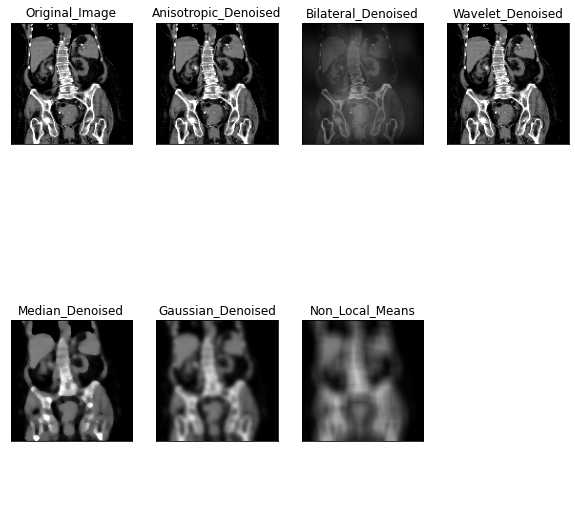

In [14]:
anisotropic_image = anisotropic_diffusion(Features[143,:,:,:][:,:,0], niter = 50, kappa = 5, gamma = 0.005, option=1)
bilateral_image = denoise_bilateral(Features[143], sigma_spatial = 10, channel_axis = -1)
wavelet_img = denoise_wavelet(Features[143, :, :, :], sigma = 0.12, channel_axis = -1,convert2ycbcr = True, method = 'BayesShrink', mode = 'soft', rescale_sigma = True).reshape(128, 128, 3)
median_img = median(Features[143, :, :, :][:,:,0], disk(3), mode = 'constant', cval = 0.0).reshape(128, 128, 1)
guassian_img = nd.gaussian_filter(tuple(Features[143, :, :, :]), sigma = 2)
non_local_mean_img = non_local_mean(Features[143])

Processed_images = [[Features[143, :, :, :], "Original_Image"], [anisotropic_image, "Anisotropic_Denoised"], [bilateral_image, "Bilateral_Denoised"], [wavelet_img, "Wavelet_Denoised"], [median_img,"Median_Denoised"], [guassian_img, "Gaussian_Denoised"], [non_local_mean_img, "Non_Local_Means"]]

Processed(Processed_images)

In [15]:
# Denoising the given data with anisotropic Filter
true_min, true_max = np.min(Features[0]), np.max(Features[0])
dataRange = abs(true_min) + abs(true_max)
anis_denoised = []
for i in range(len(Features)):
    anisotropic_image = anisotropic_diffusion(Features[i,:,:,:], niter = 100, kappa = 10, gamma = 0.02, option = 1)
    anis_denoised.append(anisotropic_image)
anis_denoised = np.array(anis_denoised)

## Cropping, Thersholding(or masking), Edge Detection, Morphological Analysis

In [16]:
def crop(image_to_be_cropped):
    height, width = image_to_be_cropped.shape[:2]
    start_row, start_col = int(height * .24), int(width * .24)
    end_row, end_col = int(height * .78), int(width * .78)
#     start_row, start_col = int(height * .24), int(width * .24)
#     end_row, end_col = int(height * .42), int(width * .78)
    cropped_image = image_to_be_cropped[start_row:end_row, start_col:end_col]
    return cropped_image

def threshold(img, thresh1 = 254):
    return ((img > thresh1) * 255).astype('uint8')


# Canny edge detection is a technique to extract useful structural information from different vision objects and dramatically reduce the amount of data to be processed. 
def edge_detection(Image):
    img = cv2.Canny(Image, 100, 200)
    return img

# To see the pixel values division in the images
def hist_plot(Image):
    plt.hist(Image.flat, bins = 100, range = (0, 255))
    plt.show()

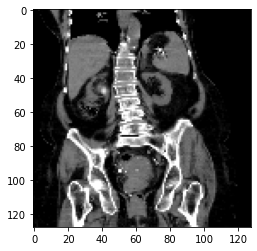

In [17]:
# Convert BGR image to Gray Scale image
gray_image = cv2.cvtColor(data[143][0], cv2.COLOR_BGR2GRAY)

# expanding dimensions from 128,128 to 128,128,1
gray_image = np.expand_dims(gray_image, axis = -1)

plt.imshow(gray_image, cmap = "gray")
plt.show()

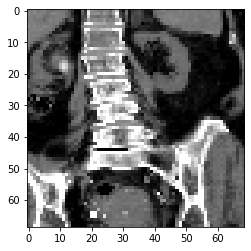

In [18]:
# Crop a Image
cropped_image = crop(Features[143,:,:,:])
plt.imshow(cropped_image)
plt.show()

In [19]:
cropped_image.shape

(69, 69, 3)

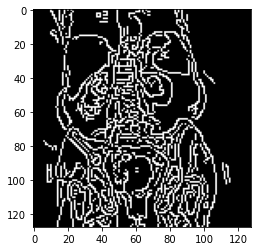

In [20]:
# Edge Detection
img = edge_detection(gray_image)
plt.imshow(img, cmap = "gray")
plt.show()

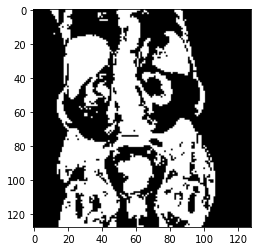

In [21]:
# Threshold masking using OTSU method
# Automatic Thresholding
# Otsu's method looks at every possible value for the threshold between background and foreground, calculates the variance within each of the two clusters, and selects the value for which the weighted sum of these variances is the least.
re, th = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(th, cmap = "gray")
plt.show()

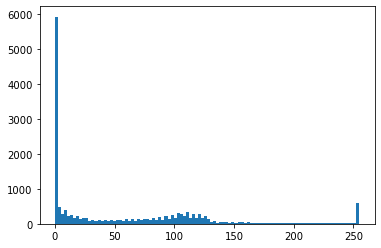

In [22]:
# See the pixel values division in the images
hist_plot(gray_image)

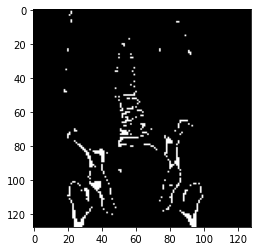

In [23]:
# Manual Thresholding on the basis of pixel divisions
img = threshold(gray_image)
plt.imshow(img, cmap = "gray")
plt.show()

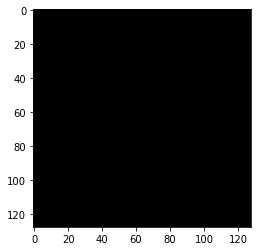

In [24]:
# Mask of Image

# HSV or Hue Saturation Value is used to separate image luminance from color information. This makes it easier when we are working on or need luminance of the image/frame. HSV also used in situations where color description plays an integral role.
# Hue, in the context of color and graphics, refers to the attribute of a visible light due to which it is differentiated from or similar to the primary colors
# Saturation describes the intensity of the color.
# Hue is determined by the dominant wavelength of the visible spectrum. It is the attribute that permits colors to be classified as red, yellow, green, blue, or an intermediate color. Saturation pertains the amount of white light mixed with a hue.
# Value works in conjunction with saturation and describes the brightness or intensity of the color, from 0 to 100 percent, where 0 is completely black, and 100 is the brightest and reveals the most color.

lower_yellow = np.array([35, 255, 255])
upper_yellow = np.array([25, 50, 70])
lower_blue = np.array([110,50,50])
upper_blue = np.array([130,255,255])
lower_white = np.array([180, 18, 255])
upper_white = np.array([0, 0, 231])
lower_black = np.array([180, 255, 30])
upper_black = np.array([0, 0, 0])

bgr_image = cv2.cvtColor(Features[143,:,:][:,:,0], cv2.COLOR_GRAY2BGR)

hsv = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv, lower_black, upper_black)

detected_output = cv2.bitwise_and(hsv, hsv, mask =  mask)
plt.imshow(detected_output, cmap = "gray")
plt.show()

In [25]:
# Crop all the input images
Cropped_Features = []
for i in range(len(Features)):
    cropped_image = crop(Features[i,:,:,:])
    Cropped_Features.append(cropped_image)
Cropped_Features = np.array(Cropped_Features)

In [26]:
# Denoise all the input images with Bilateral Filte

# On original images
bil_de = []
for i in range(len(Features)):
    bilateral_de = cv2.bilateralFilter(Features[i], 15, 75, 75)
    bil_de.append(bilateral_de)
bil_de = np.array(bil_de)


# On cropped images
bilateral_denoised = []
for i in range(len(Cropped_Features)):
    bilateral = cv2.bilateralFilter(Cropped_Features[i], 15, 75, 75)
    bilateral_denoised.append(bilateral)
bilateral_denoised = np.array(bilateral_denoised)

In [27]:
# Threshold masking on all the input images

# Original
thresholded = []
for i in range(len(bilateral_denoised)):
    temp = threshold(bilateral_denoised[i])
    thresholded.append(temp)
thresholded = np.array(thresholded)


# Cropped
thresholded = []
for i in range(len(Cropped_Features)):
    temp = threshold(Cropped_Features[i])
    thresholded.append(temp)
thresholded = np.array(thresholded)

### SPLITTING OF DATA

In [28]:
print(Features.shape)
print(Labels.shape)

(1609, 128, 128, 3)
(1609,)


In [29]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(Features, Labels, test_size = 0.30, random_state = 80, shuffle = True)

print(len(Xtrain), len(Xtest), len(Ytrain), len(Ytest))

# Converting the list to a numpy array as a requirement for the input in fit function.
Xtrain=np.array(Xtrain)
Xtest=np.array(Xtest)
Ytrain=np.array(Ytrain)
Ytest=np.array(Ytest)

1126 483 1126 483


In [49]:
from tensorflow.keras.optimizers import SGD

In [50]:
model3 = Sequential()

model3.add(Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3), padding='same'))
model3.add(MaxPool2D(2))
model3.add(Dropout(0.2))

model3.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model3.add(MaxPool2D(pool_size=(2,2), strides = 2))
model3.add(Dropout(0.4))

model3.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model3.add(MaxPool2D(pool_size=(2,2), strides = 2))
model3.add(Dropout(0.5))

model3.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model3.add(MaxPool2D(pool_size=(2,2), strides = 2))

model3.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model3.add(MaxPool2D(pool_size=(2,2), strides = 2))

model3.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model3.add(MaxPool2D(pool_size=(2,2), strides = 2))
model3.add(Dropout(0.6))
model3.add(Flatten())
model3.add(Dense(512, activation='relu'))

model3.add(Dense(1, activation='sigmoid'))

model3.compile(loss = "binary_crossentropy", optimizer = Adam(learning_rate=0.001), metrics=['accuracy'])


### Different types of Model Training and Testing

#### CONVOLUTIONAL NEURAL NETWORK(CNN)

In [51]:
# verbose=2 just specifies how much output to the console we want to see during each epoch of training. The verbosity levels range from 0 to 2, so we're getting the most verbose output.
# model.fit(Xtrain, Ytrain, epochs = 50, batch_size = 20, verbose = 2)

# Define a callback for early stopping
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10)

# Train the model
history = model3.fit(Xtrain, Ytrain, epochs = 200, batch_size = 20, callbacks = [early_stopping])


#To this function, we pass in the test samples x, specify a batch_size, and specify which level of verbosity we want from log messages during prediction generation. The output from the predictions won't be relevant for us, so we're setting verbose=0 for no output.
#Note that, unlike with training and validation sets, we do not pass the labels of the test set to the model during the inference stage.
predictions = model3.predict(x = Xtest, batch_size = 20, verbose = 0)
Accuracy = model3.evaluate(Xtest, Ytest, verbose = 0)
print("Accuracy: ", Accuracy[1] * 100)

Epoch 1/200
57/57 [==============================] - 19s 291ms/step - loss: 9.2786 - accuracy: 0.4787
Epoch 2/200
57/57 [==============================] - 16s 283ms/step - loss: 0.7089 - accuracy: 0.5080
Epoch 3/200
57/57 [==============================] - 17s 295ms/step - loss: 0.6944 - accuracy: 0.5169
Epoch 4/200
57/57 [==============================] - 18s 323ms/step - loss: 0.6989 - accuracy: 0.5266
Epoch 5/200
57/57 [==============================] - 19s 332ms/step - loss: 0.6980 - accuracy: 0.5160
Epoch 6/200
57/57 [==============================] - 24s 417ms/step - loss: 0.6983 - accuracy: 0.5027
Epoch 7/200
57/57 [==============================] - 23s 406ms/step - loss: 0.6969 - accuracy: 0.5098
Epoch 8/200
57/57 [==============================] - 22s 387ms/step - loss: 0.6946 - accuracy: 0.5169
Epoch 9/200
57/57 [==============================] - 23s 400ms/step - loss: 0.6986 - accuracy: 0.5053
Epoch 10/200
57/57 [==============================] - 20s 347ms/step - loss: 0.692

# SVM CLASSIFIER

In [52]:
Xtrain.shape

(1126, 128, 128, 3)

In [53]:
Xtest.shape

(483, 128, 128, 3)

In [54]:
Xtrain_SVC = Xtrain.reshape(1126, 128 * 128 * 3)
Xtest_SVC = Xtest.reshape(483, 128 * 128 * 3)

In [55]:
model_SVC = SVC(C = 1,kernel='poly',gamma = 'auto')
model_SVC.fit(Xtrain_SVC, Ytrain)

SVC(C=1, gamma='auto', kernel='poly')

In [56]:
prediction = model_SVC.predict(Xtest_SVC)
accuracy = model_SVC.score(Xtest_SVC , Ytest)

In [57]:
train_accuracy = model_SVC.score(Xtrain_SVC, Ytrain)
print("Train_Accuracy", train_accuracy * 100)

Train_Accuracy 100.0


In [58]:
print("Test_Accuracy ",accuracy * 100)

Test_Accuracy  93.16770186335404


## Confusion Matrix 

In [59]:
# cm = confusion_matrix(y_true = Ytest, y_pred = np.argmax(predictions,axis=-1))
cm = confusion_matrix(Ytest , (prediction > 0.75) * 1)

In [60]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[204  25]
 [  8 246]]


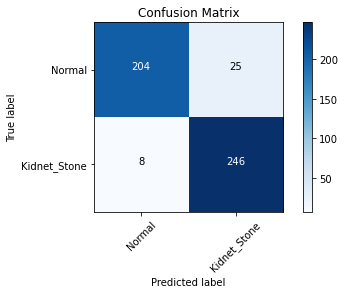

In [61]:
cm_plot_labels = ['Normal','Kidnet_Stone']
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = 'Confusion Matrix')

In [62]:
def image_prediction(img):
    plt.imshow(img)
    img1=img.reshape(1,128,128,3)
    predict = model3.predict(img1)
    if ((predict > 0.75) * 1):
        print("The condition is normal and stable.")
    else:
        print("Person is having kidney stone(s)")

1/1 [==============================] - 0s 32ms/step
Person is having kidney stone(s)


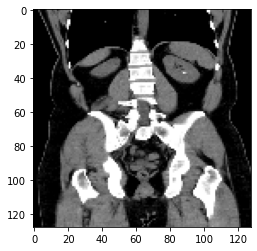

In [63]:
image_prediction(Xtest[150])

1/1 [==============================] - 0s 34ms/step
The condition is normal and stable.


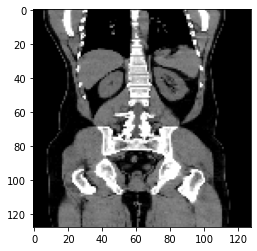

In [64]:
image_prediction(Xtest[50])

In [ ]:
!pip install split-folders

In [74]:
def image_prediction_KMeans(img):
    img = img.reshape(128,128,3)
    plt.imshow(img)
    img1 = img.reshape(1, 128 * 128 * 3)
    predict = kmeans_model.predict(img1)
    print(predict)
    if (predict):
        print("Person is having kidney stone(s)")
    else:
        print("The condition is normal and stable.")

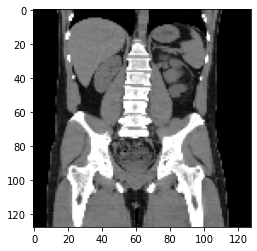

In [77]:
path_2 = "C:/Users/prajwal mr/Downloads/archive/CT_SCAN/Normal/N1.png"
image_array_2 = cv2.imread(path_2)
new_image_2 = cv2.resize(image_array_2,(128,128))
plt.imshow(new_image_2)
plt.show()

In [95]:
model3.save('kidney_stones_model.h5')